# トピックモデリング

自然言語で書かれた文章に対するデータマイニングをする必要があるとしましょう。

文章中に現れる単語は同じ綴りであっても異なる意味を持っている場合があります。
同じ綴りであっても名詞と動詞などのように文法的に違う場合は、構文規則などに従った解析などで区別できるかもしれませんが、
品詞が同じでも意味が違う場合は、周りに存在する単語を勘案してどの意味で使われているのかを判断する必要があります。

逆に言うと、真面目に構文解析などを行わなくても、共起する単語のセットを文章の背後に潜んでいる「潜在トピック」と考えることで、単語や文章について意味とかを扱える、ということになります。

* 個々の文書 = 複数のトピックを混合したもの
* 個々のトピック = 複数の単語が、個々のトピック毎に決まった割合で出現

と、考えるということになります。

文章の背後に潜んでいる潜在トピックは、数学的には、データに直接現れない潜在変数として扱うことになるので、それを用いて自分の解きたい問題を完全にモデル化するとなると、数学的にも、またそれを数値的に解くのも大変です。（それを真面目に扱っている佐藤先生の「トピックモデルによる統計的潜在意味解析」（オーム社）という教科書があります。）

ですが、既存の潜在意味解析のライブラリを使うと、出来ることは限定的ではありますが、文章をトピックで表現する（＝次元削減）ことで、普通の機械学習のアルゴリズム（回帰や識別、クラスタリングなど）に使用できるようになります --- ということを前回お話ししました。いわゆる「次元の呪い」を避けるために次元削減することは重要です。

また、文書 $\rightarrow$ 顧客、単語 $\rightarrow$ 購入アイテム、と読み替えを行えば、潜在トピック $\rightarrow$ 潜在的な購買傾向、と考えることもできます。すると、潜在意味解析は商品リコメンデーションなどにそのまま応用できると考えられます。

そこで今回は、gensim と呼ばれるライブラリの使い方をメインに扱います。

# 20 newsgroups

実際に我々が仕事で解析したい文章はおそらく日本語の文書であろうかと思われます。日本語の文書を解析する際には、形態素解析を使って文書の前処理をすることが多いと思いますので、授業の後半で python で形態素解析ライブラリを呼ぶ話をし、gensim の使い方自体は形態素解析が不要な英文で学ぶことにします。

下記で gensim のライブラリのロードに失敗する場合は、一度 ipython notebook を閉じて
````
$ pip install gensim
````
のようにライブラリを導入してから、ipython notebook を再起動してください。

また、`nltk` がファイルダウンロードが必要だとエラーを出してきた場合は、コマンドラインシェルから

````
$ ipython

In [1]: import nltk

In [2]: nltk.download()
````

のように入力すると、GUI のウィンドウが開くので、`all` をダウンロードしてください。（完了したら GUI のウィンドウを閉じて良い。また、多分不要なはず。）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim import corpora, models, similarities

解析対象としていつもの 20 newsgroup データセットを使用します。下記を実行すると、ダウンロードに時間がかかる旨の WARNING が出ます。

In [2]:
texts0 = fetch_20newsgroups().data

含まれる文書の数と、含まれているデータの形式は下記のようになります。

In [3]:
len(texts0)

11314

In [4]:
print(texts0[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
texts = ['\n'.join(text.split('\n')[6:]) for text in texts0]
texts[0]

u' I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n'

newsgroup 記事としての各種ヘッダなどが含まれており、実務で解析する場合はそれらを除去するなど色々工夫すべき箇所があるかと思いますが、今回は非常に簡単にヘッダと思われる最初の６行をスキップして単語のリストに分解し、適当な前処理をしようと思います。

`split()` は文字列をwhitespace文字で分割し、`lower()` は小文字化します。`re` ライブラリを使ってアルファベット以外の文字を消去します。
短すぎる単語(a とか is とか)や、長すぎる単語(ドメイン名とか)も捨てます。
英単語の語幹を取り出すアルゴリズムは nltk ライブラリには色々な stemming アルゴリズムが実装されていますが、簡単に正規表現で指定する `RegexpStemmer` を使用しました。また、stopword リストを作るのも今回は省略し、gensim の dictionary の機能に任せることにします。

`wordss` は文字列のリストのリストになります。

In [6]:
#wordss = [[word for (word,tag) in pos_tag(word_tokenize(text)) \
#           if ((tag == 'NN') or (tag == 'NNP')) ] for text in texts]
from nltk.stem import RegexpStemmer
import re
regex = re.compile('[^a-zA-Z]')
st = RegexpStemmer('ing$|s$|e$|able$', min=4)
wordss = [[st.stem(regex.sub('', word.lower())) for word in text.split() if 4 < len(word) < 10] for text in texts]

今回はテキストの総量が少ないため、文書全体をリストとして保持しています。gensim は文書にランダムアクセスを必要としないため、ドキュメントの[Corpus Streaming – One Document at a Time](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) の記述を参考にすれば、必要に応じてテキストファイルから一行づつ文章を取得するイテレータとして実装することも可能です。

In [7]:
wordss[0]

[u'wonder',
 u'anyon',
 u'ther',
 u'could',
 u'enlighten',
 u'other',
 u'door',
 u'sport',
 u'looked',
 u'early',
 u'called',
 u'bricklin',
 u'door',
 u'really',
 u'small',
 u'addition',
 u'front',
 u'bumper',
 u'separat',
 u'body',
 u'know',
 u'anyon',
 u'tellm',
 u'model',
 u'nam',
 u'engin',
 u'spec',
 u'year',
 u'wher',
 u'mad',
 u'history',
 u'whatever',
 u'funky',
 u'look',
 u'pleas',
 u'email',
 u'thank',
 u'brought',
 u'lerxst']

上記の単語のリストのリストから、「単語 $\leftrightarrow$ 単語ID」の変換を行う辞書を作成します。今回は `wordss` を与えて一気に作成していますが、ふ大きなファイルから一文章づつ辞書に追加していく `add_documents` メソッドなどもあります。

できた辞書から、出現頻度が少なすぎたり多すぎたりする単語を削除します。dictionary はファイルに save/load できます。

In [8]:
dictionary = corpora.Dictionary(wordss)
dictionary.filter_extremes(no_below=50, no_above=0.1)
dictionary.compactify()
str(dictionary)

"Dictionary(2459 unique tokens: [u'limited', u'selann', u'dynamic', u'catch', u'sleep']...)"

Bag-of-Words 表現は dictionary を使ってこんな感じで得られます。この状態のデータを `corpora.MmCorpus.serialize` を使えば中間データとしてファイルに保存出来たりしますが、出力ファイルはサイズが割と大きめです。

In [9]:
bows = [dictionary.doc2bow(words) for words in wordss]
for i,c in bows[0]:
    print dictionary.get(i), c

spec 1
door 2
history 1
engin 1
wonder 1
sport 1
model 1
early 1
separat 1
small 1
called 1
nam 1
body 1
front 1
mad 1
brought 1
looked 1
addition 1
know 1
whatever 1


Bag-of-words の単語出現回数は、通常は Tf-Idf (Term Frequency(単語の出現頻度) $\times$ Inverse Document Frequency (文書頻度の逆数)) に変換して用いることが多いかと思います。

Bag-of-words から `tfidf_model` を作成し、bows を変換します。

In [10]:
tfidf_model = models.TfidfModel(bows, normalize=True)
print str(tfidf_model)
tfidfs = tfidf_model[bows]
for i,tfidf in tfidf_model[bows[0]]:
    print dictionary.get(i), tfidf

TfidfModel(num_docs=11314, num_nnz=436786)
spec 0.247740938814
door 0.48991700211
history 0.182941539255
engin 0.220363090001
wonder 0.16700783001
sport 0.229373572547
model 0.179354757006
early 0.185873153278
separat 0.224216878156
small 0.16005216173
called 0.144533517182
nam 0.202307890205
body 0.247740938814
front 0.191757677553
mad 0.233229293596
brought 0.209988383367
looked 0.200696329894
addition 0.212154386206
know 0.127904071636
whatever 0.182656978796


LDA のトピックモデリングに先立って LSI (Latent Semantic Indexing) による解析を行ってみましょう。これは商品推薦アルゴリズムでは行列分解といわれるものに相当します。

LSI を行うことで、文章が 500 次元のベクトルで表現されていることが判ります。

固有値の値をプロットしてみます。トピックの数としては 100 も取れば十分そうに見えます。

LsiModel(num_terms=2459, num_topics=500, decay=1.0, chunksize=20000)


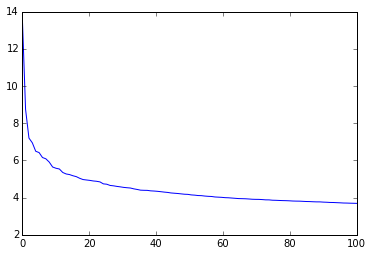

In [11]:
lsi_model = models.LsiModel(tfidfs, id2word=dictionary, num_topics=500)
print str(lsi_model)
l = len(lsi_model.projection.s)
plt.plot(np.linspace(0,100,100), lsi_model.projection.s[:100])
plt.show()
# print lsi_model[tfidf_model[bows[0]]]

次に、トピックモデリングのモデルとしてとして LDA (Latent Dirichlet Allocation) を使ってモデル化してみます。今回はトピックの数を上の議論により100に設定してみました。
文章が、100次元のベクトルとして表現されていることが判ります。

使用可能なアルゴリズムは、[gensim のドキュメント記述](https://radimrehurek.com/gensim/tut2.html#available-transformations)を読むと、LSI, random projection など幾つか選択肢があることが判ります。

計算した `lda_model` も save/load メソッドでファイルに記録したり読みだしたりできます。

`print_topics` メソッドの出力を眺めると、何をトピックと認識してるのかがわかります。

注意：LDA はランダムな初期値から収束するまで計算させるので、結果は乱数で変わります。同じ結果になりません。

In [12]:
lda_model = models.LdaModel(tfidfs, id2word=dictionary, num_topics=20, iterations=500)
print str(lda_model)
lda_model.print_topics(num_topics=20)

LdaModel(num_terms=2459, num_topics=20, decay=0.5, chunksize=2000, alpha=[ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05])


[u'0.005*israel + 0.004*jesu + 0.004*israeli + 0.004*spac + 0.004*earth + 0.003*jewish + 0.003*greek + 0.003*orbit + 0.003*stat + 0.003*world',
 u'0.012*armenian + 0.009*russian + 0.009*ticket + 0.008*steal + 0.007*david + 0.006*citizen + 0.006*japanes + 0.006*bodie + 0.006*armenia + 0.006*turkish',
 u'0.024*monitor + 0.022*video + 0.017*card + 0.014*pric + 0.012*driver + 0.011*simm + 0.010*board + 0.010*offer + 0.010*speed + 0.009*centri',
 u'0.007*engin + 0.006*driv + 0.006*chip + 0.005*power + 0.005*motorola + 0.005*intel + 0.005*dealer + 0.005*appl + 0.004*model + 0.004*driver',
 u'0.010*doug + 0.009*phil + 0.009*penalty + 0.007*repost + 0.007*commit + 0.007*jackson + 0.006*blood + 0.006*grad + 0.006*macintosh + 0.006*beach',
 u'0.006*weapon + 0.004*koresh + 0.004*firearm + 0.003*polic + 0.003*criminal + 0.003*crim + 0.003*them + 0.003*compound + 0.003*member + 0.003*children',
 u'0.012*rid + 0.008*rider + 0.006*fax + 0.006*uniform + 0.006*tape + 0.005*editor + 0.005*edition + 0.00

文章#1 のトピックを見てみましょう。

In [13]:
print lda_model[tfidf_model[bows[1]]]
for topic_id, weight in lda_model[tfidf_model[bows[1]]]:
    print 'weight=',weight,', topic=',lda_model.print_topic(topic_id, topn=20)
print texts[1]

[(0, 0.34520911271624627), (2, 0.47686740045921261)]
weight= 0.345613891544 , topic= 0.005*israel + 0.004*jesu + 0.004*israeli + 0.004*spac + 0.004*earth + 0.003*jewish + 0.003*greek + 0.003*orbit + 0.003*stat + 0.003*world + 0.003*muslim + 0.002*attack + 0.002*christ + 0.002*heard + 0.002*religion + 0.002*human + 0.002*against + 0.002*power + 0.002*father + 0.002*moon
weight= 0.476462621634 , topic= 0.024*monitor + 0.022*video + 0.017*card + 0.014*pric + 0.012*driver + 0.011*simm + 0.010*board + 0.010*offer + 0.010*speed + 0.009*centri + 0.009*quadra + 0.008*digital + 0.008*stereo + 0.008*mous + 0.008*speaker + 0.008*c + 0.007*bit + 0.007*channel + 0.007*color + 0.007*sal
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, 

gensim は上記のベクトル表現を用いて、文書の類似度を計算する機能もあります。最も似ている文書を5個返すように指定します。

In [14]:
index = similarities.MatrixSimilarity(lda_model[tfidfs], num_features=100)
index.num_best = 5

最初の文章に似ている文章を求めてみます

In [15]:
for i,sim in index[lda_model[tfidf_model[bows[1]]]]:
    print i,'-->',sim
    print texts[i]

1 --> 0.999994695187
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>

2945 --> 0.997648596764
>
>	I have an Adlib sound board for sale.  It includes
>	the original disks, and I'll throw in a Windows 3.1
>	.WAV sound file driver.  For those of you that are
>	using your PC Speaker for games, this will be a much
>	welcomed board for your PC!
>
>	$70.00 includes shipping to your home or office.
>
>	Email: bitzm@columbia.dsu.edu


実は、文章#1 はコンピュータ関係の文章としてきれいに識別できていますが、文章#0 はあまりきれいに識別できていません。
（時間があれば、1 を 0 に変えて眺めてみてください。）